# Task 2 Multiclass classification Baseline

In this class, we will develop a baseline for Task 2 using the chess dataset. We will model the task as an multiclass classification task.

In [1]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2, json
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import models
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image

random.seed(42)

### Connect Colab to Drive (if the dataset is on drive)

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#!unzip "drive/MyDrive/Dataset/images.zip" -d "."
#!cp "drive/MyDrive/Dataset/annotations.json" -d "."

In [4]:
# Define the model
# Define model
weights = models.ResNet50_Weights.IMAGENET1K_V2
model = models.resnet50(weights=weights)
transforms1 = weights.transforms()

## Load dataset

**Tip**: since the images are very big, resize the dataset before loading it to save time and memory during training (use cubic interpolation to preserve image quality when downsizing the images)!

In [5]:
# Normalize images
data_aug = transforms.Compose([
    transforms.ToImage(),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.95, 1.05)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomRotation(degrees=5),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_in = transforms1
"""transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])"""

'transforms.Compose([\n    transforms.ToImage(),\n    transforms.Resize((256, 256)),\n    transforms.CenterCrop((224, 224)),\n    transforms.ToDtype(torch.float32, scale=True),\n    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])\n])'

In [6]:
def chesspos2number(chesspos):
    col = ord(chesspos[0])-ord('a')
    row = int(chesspos[1])-1
    return row, col

class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        self.ids = np.asarray(self.ids)
        self.boards = torch.zeros((len(self.file_names), 8, 8))
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            self.boards[idx][row][col] = 1

        if partition == 'train':
            self.split_ids = np.asarray(self.anns['splits']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.boards = self.boards[self.split_ids]
        self.num_pieces = torch.sum(self.boards.view(len(self.boards), 64), axis=-1)#/32
        #self.num_pieces = F.one_hot(self.num_pieces.long()-1, 32)
        self.ids = self.ids[self.split_ids]

        self.transform = transform
        print(f"Number of {partition} images: {len(self.file_names)}")
        self.images = {}
        for i in range(len(self.file_names)):
            #image = cv2.imread(os.path.join(self.root, self.file_names[i]))
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.open(os.path.join(self.root, self.file_names[i]))
            if self.transform:
                image = self.transform(image)
            self.images[self.file_names[i]] = image

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image = self.images[self.file_names[i]]

        num_pieces = self.num_pieces[i]

        return image, num_pieces.float()

train_dataset = ChessDataset('..', 'train', data_aug)
valid_dataset = ChessDataset('..', 'valid', data_in)
test_dataset = ChessDataset('..', 'test', data_in)

Number of train images: 6479
Number of valid images: 2192
Number of test images: 2129


In [7]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 8
num_workers = 0 # how many processes are used to load the data

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Using cuda device


torch.Size([8, 224, 224, 3])
torch.Size([8])
tensor(1)


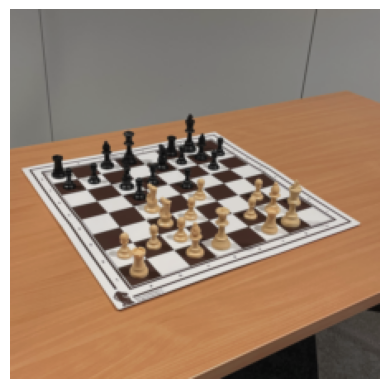

In [8]:
for batch in train_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    print(labels.shape)
    print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[0])
    plt.axis('off')
    plt.show()

    break

## Defining the model

We will use a pre-trained ResNet50 network.

In [9]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


#for param in model:
#    param.requires_grad = False
# change the number of neurons in the last layer to the number of classes of the problem at hand (maximum number of pieces on a chess game)
# TODO
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Linear(512, 1),
    nn.Sigmoid()
)

model.to(device)

Using cuda device


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Train the model

Define function to perform one iteration

In [10]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device).unsqueeze(1) # remove the last dimension
        
          # Compute prediction error
          
          pred = model(X)
          scaled_pred = (pred * 31 + 1)#.round() # Scale [0,1] → [1,32] and round
          #scaled_pred = model(X)
          #print(scaled_pred.shape,y.shape)
          loss = loss_fn(scaled_pred, y)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          preds.extend(scaled_pred.cpu().detach().numpy())
          #print(final_pred.cpu().numpy())
          #original_values =y.cpu().argmax(dim=-1) + 1
          labels.extend(y.cpu())
          #print(original_values)
    return total_loss / num_batches, mean_absolute_error(preds, labels)

Define function to train a model

In [11]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
  train_history = {'loss': [], 'accuracy': []}
  val_history = {'loss': [], 'accuracy': []}
  best_val_loss = np.inf
  print("Start training...")
  for t in range(num_epochs):
      print(f"\nEpoch {t+1}")
      train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)
      print(f"Train loss: {train_loss:.5f} \t Train acc: {train_acc:.5f}")
      val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
      print(f"Val loss: {val_loss:.5f} \t Val acc: {val_acc:.5f}")

      # save model when val loss improves
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_name + '_best_model.pth')

      # save latest model
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, model_name + '_latest_model.pth')

      # save training history for plotting purposes
      train_history["loss"].append(train_loss)
      train_history["accuracy"].append(train_acc)

      val_history["loss"].append(val_loss)
      val_history["accuracy"].append(val_acc)
      
  print("Finished")
  return train_history, val_history

Define loss, optimizer and train the model

In [12]:
# Define loss function
loss_fn = nn.MSELoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
#optimizer = torch.optim.SGD(model.parameters(), lr=5e-5, momentum=0.9)
num_epochs = 50

# TODO - Train the model
train_history, val_history = train(model, 'chess_model', num_epochs, train_dataloader, valid_dataloader, loss_fn, optimizer)

Start training...

Epoch 1


100%|██████████| 809/809 [00:41<00:00, 19.33it/s]


Train loss: 11.99479 	 Train acc: 2.57630


100%|██████████| 274/274 [00:04<00:00, 59.35it/s]


Val loss: 2.31248 	 Val acc: 1.19353

Epoch 2


100%|██████████| 809/809 [00:41<00:00, 19.65it/s]


Train loss: 3.33710 	 Train acc: 1.43241


100%|██████████| 274/274 [00:04<00:00, 60.90it/s]


Val loss: 2.79654 	 Val acc: 1.34349

Epoch 3


100%|██████████| 809/809 [00:40<00:00, 19.74it/s]


Train loss: 1.65811 	 Train acc: 1.01730


100%|██████████| 274/274 [00:04<00:00, 59.87it/s]


Val loss: 1.40230 	 Val acc: 0.93521

Epoch 4


100%|██████████| 809/809 [00:43<00:00, 18.69it/s]


Train loss: 1.11450 	 Train acc: 0.83687


100%|██████████| 274/274 [00:04<00:00, 58.06it/s]


Val loss: 1.26724 	 Val acc: 0.88886

Epoch 5


100%|██████████| 809/809 [00:43<00:00, 18.63it/s]


Train loss: 0.78023 	 Train acc: 0.69900


100%|██████████| 274/274 [00:04<00:00, 57.85it/s]


Val loss: 1.02341 	 Val acc: 0.78766

Epoch 6


100%|██████████| 809/809 [00:42<00:00, 18.91it/s]


Train loss: 0.70484 	 Train acc: 0.65925


100%|██████████| 274/274 [00:04<00:00, 58.24it/s]


Val loss: 1.18040 	 Val acc: 0.82644

Epoch 7


100%|██████████| 809/809 [00:43<00:00, 18.79it/s]


Train loss: 0.67976 	 Train acc: 0.64236


100%|██████████| 274/274 [00:04<00:00, 57.67it/s]


Val loss: 1.16790 	 Val acc: 0.80693

Epoch 8


100%|██████████| 809/809 [00:43<00:00, 18.72it/s]


Train loss: 0.61100 	 Train acc: 0.61032


100%|██████████| 274/274 [00:04<00:00, 57.68it/s]


Val loss: 1.04397 	 Val acc: 0.80001

Epoch 9


100%|██████████| 809/809 [00:42<00:00, 18.99it/s]


Train loss: 0.56523 	 Train acc: 0.58045


100%|██████████| 274/274 [00:04<00:00, 58.21it/s]


Val loss: 0.97030 	 Val acc: 0.76221

Epoch 10


100%|██████████| 809/809 [00:43<00:00, 18.72it/s]


Train loss: 0.53198 	 Train acc: 0.56583


100%|██████████| 274/274 [00:04<00:00, 57.90it/s]


Val loss: 0.77471 	 Val acc: 0.67453

Epoch 11


100%|██████████| 809/809 [00:43<00:00, 18.65it/s]


Train loss: 0.48402 	 Train acc: 0.53707


100%|██████████| 274/274 [00:04<00:00, 57.67it/s]


Val loss: 1.11367 	 Val acc: 0.83579

Epoch 12


100%|██████████| 809/809 [00:43<00:00, 18.68it/s]


Train loss: 0.42734 	 Train acc: 0.50812


100%|██████████| 274/274 [00:04<00:00, 58.55it/s]


Val loss: 0.74079 	 Val acc: 0.65558

Epoch 13


100%|██████████| 809/809 [00:42<00:00, 18.89it/s]


Train loss: 0.38477 	 Train acc: 0.47569


100%|██████████| 274/274 [00:04<00:00, 58.18it/s]


Val loss: 0.75848 	 Val acc: 0.67621

Epoch 14


100%|██████████| 809/809 [00:42<00:00, 18.89it/s]


Train loss: 0.36952 	 Train acc: 0.46396


100%|██████████| 274/274 [00:04<00:00, 58.05it/s]


Val loss: 0.85343 	 Val acc: 0.72657

Epoch 15


100%|██████████| 809/809 [00:43<00:00, 18.63it/s]


Train loss: 0.38061 	 Train acc: 0.46889


100%|██████████| 274/274 [00:04<00:00, 56.69it/s]


Val loss: 1.17254 	 Val acc: 0.85890

Epoch 16


100%|██████████| 809/809 [00:42<00:00, 18.90it/s]


Train loss: 0.31316 	 Train acc: 0.42562


100%|██████████| 274/274 [00:04<00:00, 58.54it/s]


Val loss: 0.62004 	 Val acc: 0.61131

Epoch 17


100%|██████████| 809/809 [00:43<00:00, 18.75it/s]


Train loss: 0.27805 	 Train acc: 0.40322


100%|██████████| 274/274 [00:04<00:00, 58.30it/s]


Val loss: 0.62398 	 Val acc: 0.61010

Epoch 18


100%|██████████| 809/809 [00:43<00:00, 18.74it/s]


Train loss: 0.25343 	 Train acc: 0.38249


100%|██████████| 274/274 [00:04<00:00, 58.76it/s]


Val loss: 0.59605 	 Val acc: 0.59562

Epoch 19


100%|██████████| 809/809 [00:42<00:00, 18.96it/s]


Train loss: 0.26306 	 Train acc: 0.39272


100%|██████████| 274/274 [00:04<00:00, 58.60it/s]


Val loss: 0.60755 	 Val acc: 0.59416

Epoch 20


100%|██████████| 809/809 [00:42<00:00, 18.98it/s]


Train loss: 0.24237 	 Train acc: 0.37373


100%|██████████| 274/274 [00:04<00:00, 58.63it/s]


Val loss: 0.51950 	 Val acc: 0.55019

Epoch 21


100%|██████████| 809/809 [00:42<00:00, 18.98it/s]


Train loss: 0.21755 	 Train acc: 0.35476


100%|██████████| 274/274 [00:04<00:00, 58.49it/s]


Val loss: 0.52429 	 Val acc: 0.55454

Epoch 22


100%|██████████| 809/809 [00:42<00:00, 18.96it/s]


Train loss: 0.22278 	 Train acc: 0.35975


100%|██████████| 274/274 [00:04<00:00, 58.75it/s]


Val loss: 0.81476 	 Val acc: 0.70107

Epoch 23


100%|██████████| 809/809 [00:42<00:00, 18.96it/s]


Train loss: 0.20886 	 Train acc: 0.34260


100%|██████████| 274/274 [00:04<00:00, 58.34it/s]


Val loss: 0.59402 	 Val acc: 0.60055

Epoch 24


100%|██████████| 809/809 [00:42<00:00, 18.83it/s]


Train loss: 0.20602 	 Train acc: 0.34335


100%|██████████| 274/274 [00:04<00:00, 57.91it/s]


Val loss: 0.52102 	 Val acc: 0.54685

Epoch 25


100%|██████████| 809/809 [00:42<00:00, 18.88it/s]


Train loss: 0.18602 	 Train acc: 0.32479


100%|██████████| 274/274 [00:04<00:00, 58.80it/s]


Val loss: 0.57540 	 Val acc: 0.58345

Epoch 26


100%|██████████| 809/809 [00:42<00:00, 18.82it/s]


Train loss: 0.16467 	 Train acc: 0.30812


100%|██████████| 274/274 [00:04<00:00, 58.19it/s]


Val loss: 0.55203 	 Val acc: 0.57802

Epoch 27


100%|██████████| 809/809 [00:42<00:00, 18.98it/s]


Train loss: 0.17326 	 Train acc: 0.31328


100%|██████████| 274/274 [00:04<00:00, 58.71it/s]


Val loss: 0.54647 	 Val acc: 0.56644

Epoch 28


100%|██████████| 809/809 [00:42<00:00, 18.99it/s]


Train loss: 0.16119 	 Train acc: 0.30086


100%|██████████| 274/274 [00:04<00:00, 58.31it/s]


Val loss: 0.49989 	 Val acc: 0.53800

Epoch 29


100%|██████████| 809/809 [00:42<00:00, 18.99it/s]


Train loss: 0.14969 	 Train acc: 0.29013


100%|██████████| 274/274 [00:04<00:00, 58.72it/s]


Val loss: 0.62953 	 Val acc: 0.61184

Epoch 30


100%|██████████| 809/809 [00:42<00:00, 18.92it/s]


Train loss: 0.14797 	 Train acc: 0.29048


100%|██████████| 274/274 [00:04<00:00, 58.80it/s]


Val loss: 0.54353 	 Val acc: 0.55904

Epoch 31


100%|██████████| 809/809 [00:43<00:00, 18.61it/s]


Train loss: 0.15630 	 Train acc: 0.29641


100%|██████████| 274/274 [00:04<00:00, 58.00it/s]


Val loss: 0.47599 	 Val acc: 0.52561

Epoch 32


100%|██████████| 809/809 [00:42<00:00, 18.89it/s]


Train loss: 0.14407 	 Train acc: 0.28386


100%|██████████| 274/274 [00:04<00:00, 58.49it/s]


Val loss: 0.57392 	 Val acc: 0.57997

Epoch 33


100%|██████████| 809/809 [00:42<00:00, 18.90it/s]


Train loss: 0.13416 	 Train acc: 0.27562


100%|██████████| 274/274 [00:04<00:00, 58.44it/s]


Val loss: 0.48288 	 Val acc: 0.53763

Epoch 34


100%|██████████| 809/809 [00:42<00:00, 18.86it/s]


Train loss: 0.14060 	 Train acc: 0.27964


100%|██████████| 274/274 [00:04<00:00, 58.11it/s]


Val loss: 0.52883 	 Val acc: 0.56174

Epoch 35


100%|██████████| 809/809 [00:42<00:00, 18.98it/s]


Train loss: 0.13203 	 Train acc: 0.27158


100%|██████████| 274/274 [00:04<00:00, 58.81it/s]


Val loss: 0.50648 	 Val acc: 0.54644

Epoch 36


100%|██████████| 809/809 [00:42<00:00, 18.98it/s]


Train loss: 0.12801 	 Train acc: 0.26620


100%|██████████| 274/274 [00:04<00:00, 58.59it/s]


Val loss: 0.53757 	 Val acc: 0.54894

Epoch 37


100%|██████████| 809/809 [00:42<00:00, 18.98it/s]


Train loss: 0.12596 	 Train acc: 0.26595


100%|██████████| 274/274 [00:04<00:00, 58.20it/s]


Val loss: 0.48578 	 Val acc: 0.52716

Epoch 38


100%|██████████| 809/809 [00:42<00:00, 19.05it/s]


Train loss: 0.11543 	 Train acc: 0.25443


100%|██████████| 274/274 [00:04<00:00, 58.23it/s]


Val loss: 0.57698 	 Val acc: 0.59397

Epoch 39


100%|██████████| 809/809 [00:42<00:00, 18.82it/s]


Train loss: 0.12472 	 Train acc: 0.26567


100%|██████████| 274/274 [00:04<00:00, 59.05it/s]


Val loss: 0.47797 	 Val acc: 0.52338

Epoch 40


100%|██████████| 809/809 [00:42<00:00, 18.96it/s]


Train loss: 0.11213 	 Train acc: 0.25017


100%|██████████| 274/274 [00:04<00:00, 58.25it/s]


Val loss: 0.48927 	 Val acc: 0.52595

Epoch 41


100%|██████████| 809/809 [00:42<00:00, 18.98it/s]


Train loss: 0.10164 	 Train acc: 0.23783


100%|██████████| 274/274 [00:04<00:00, 58.25it/s]


Val loss: 0.55177 	 Val acc: 0.57022

Epoch 42


100%|██████████| 809/809 [00:42<00:00, 18.98it/s]


Train loss: 0.09701 	 Train acc: 0.23215


100%|██████████| 274/274 [00:04<00:00, 58.56it/s]


Val loss: 0.46304 	 Val acc: 0.51492

Epoch 43


100%|██████████| 809/809 [00:42<00:00, 19.10it/s]


Train loss: 0.10247 	 Train acc: 0.23969


100%|██████████| 274/274 [00:04<00:00, 59.15it/s]


Val loss: 0.47340 	 Val acc: 0.52474

Epoch 44


100%|██████████| 809/809 [00:42<00:00, 18.86it/s]


Train loss: 0.11038 	 Train acc: 0.24666


100%|██████████| 274/274 [00:04<00:00, 58.52it/s]


Val loss: 0.54961 	 Val acc: 0.56450

Epoch 45


100%|██████████| 809/809 [00:42<00:00, 19.00it/s]


Train loss: 0.09601 	 Train acc: 0.23020


100%|██████████| 274/274 [00:04<00:00, 58.31it/s]


Val loss: 0.48790 	 Val acc: 0.53480

Epoch 46


100%|██████████| 809/809 [00:43<00:00, 18.80it/s]


Train loss: 0.09300 	 Train acc: 0.22801


100%|██████████| 274/274 [00:04<00:00, 58.37it/s]


Val loss: 0.42748 	 Val acc: 0.49962

Epoch 47


100%|██████████| 809/809 [00:42<00:00, 18.98it/s]


Train loss: 0.08390 	 Train acc: 0.21816


100%|██████████| 274/274 [00:04<00:00, 58.20it/s]


Val loss: 0.47511 	 Val acc: 0.52135

Epoch 48


100%|██████████| 809/809 [00:42<00:00, 18.93it/s]


Train loss: 0.09649 	 Train acc: 0.22849


100%|██████████| 274/274 [00:04<00:00, 58.84it/s]


Val loss: 0.46579 	 Val acc: 0.51807

Epoch 49


100%|██████████| 809/809 [00:42<00:00, 18.96it/s]


Train loss: 0.09764 	 Train acc: 0.23106


100%|██████████| 274/274 [00:04<00:00, 58.35it/s]


Val loss: 0.50848 	 Val acc: 0.54846

Epoch 50


100%|██████████| 809/809 [00:42<00:00, 19.00it/s]


Train loss: 0.08921 	 Train acc: 0.22176


100%|██████████| 274/274 [00:04<00:00, 58.42it/s]


Val loss: 0.49143 	 Val acc: 0.53076
Finished


## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

In [13]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

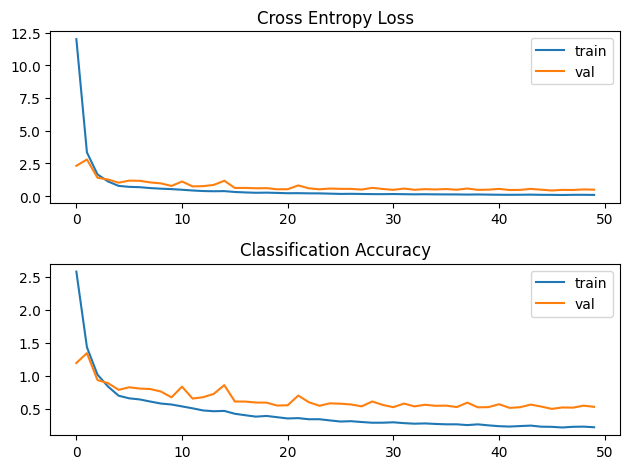

In [14]:
plotTrainingHistory(train_history, val_history)

## Test the model

Evaluate the model in the test set

In [16]:
# Load the best model
# TODO


# Evaluate model on test data
# TODO
def test(dataloader):
    preds = []
    labels = []
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)

        #probs = F.softmax(pred, dim=1)
        #final_pred = torch.argmax(probs, dim=1)
        predsTmp = pred.cpu().detach().numpy()*32
        preds.extend(predsTmp)
        #print(pred.cpu())
        #print(y.cpu())
        original_values =y.cpu()
        labels.extend(original_values)
        #print(original_values)
    return mean_absolute_error(preds, labels)
test_loss = test(test_dataloader)
print(f"Test loss: {test_loss:.3f}")

100%|██████████| 267/267 [00:05<00:00, 52.19it/s]

Test loss: 0.763


## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!

## For Group Project - Task 2: Adapt multiclass classification network to regression!

Now that you have a multiclass baseline, adapt the network for the regression problem, considering the following aspects:
* How many neurons should the last layer of a regression network have?
* What should be the final activation function for a regression network?
* What loss functions can be used to train a regression network?